# Multi-class Dog Breed Classification
Multiclass Dog Breed classification model build with TensorFlow and TensorFlow Hub

## 1. Problem
Given an image of a dog, asked to identify its breed.

## 2. Data
Data used is taken from Stanford University Dogs Dataset http://vision.stanford.edu/aditya86/ImageNetDogs/

## 3. Evaluation
The resultant model will be evaluated based on the Multi-class Log Loss.

## 4. Features
- Unstructured data (images)
- 120 Categories (dog breeds)
- Total of 20580 unique images.
- Approximately 150 images per breed.

# First, We Need to Prepare Libraries

In [1]:
#Import libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import os
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

#Check whether theres GPU available
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.6.4
TF Hub version: 0.12.0
GPU available


2022-08-05 04:31:09.358826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 04:31:09.469988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 04:31:09.470787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Data Preparation
## Retrieve the filenames, folder names and labels

In [2]:
labels = []
folder_name = []
filenames = []

for folders in os.listdir("../input/stanford-dogs-dataset/images/Images"):
    breed = "".join(folders.split("-")[1:])
    for fname in os.listdir(f"../input/stanford-dogs-dataset/images/Images/{folders}"):
        if fname[-3:] == "jpg":
            labels.append(breed)
            folder_name.append(folders)
            filenames.append(f"../input/stanford-dogs-dataset/images/Images/{folders}/{fname}")
        else:
            print(fname)

# convert to np array for convinience
labels = np.array(labels)
filenames = np.array(filenames)
len(labels), len(filenames), len(folder_name), labels[0], filenames[0], folder_name[0]

(20580,
 20580,
 20580,
 'otterhound',
 '../input/stanford-dogs-dataset/images/Images/n02091635-otterhound/n02091635_965.jpg',
 'n02091635-otterhound')

## Then we get the unique folders and labels

In [3]:
# Create unique array for both breed and folder & makes sure both are sorted in the same way
unique_breeds = np.unique(labels)
unique_folder = sorted(np.unique(folder_name), key=lambda x:"".join(x.split("-")[1:]))
len(unique_breeds), unique_breeds[:10], len(unique_folder), unique_folder[:10]

(120,
 array(['Afghan_hound', 'African_hunting_dog', 'Airedale',
        'American_Staffordshire_terrier', 'Appenzeller',
        'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog',
        'Blenheim_spaniel', 'Border_collie'], dtype='<U30'),
 120,
 ['n02088094-Afghan_hound',
  'n02116738-African_hunting_dog',
  'n02096051-Airedale',
  'n02093428-American_Staffordshire_terrier',
  'n02107908-Appenzeller',
  'n02096294-Australian_terrier',
  'n02093647-Bedlington_terrier',
  'n02107683-Bernese_mountain_dog',
  'n02086646-Blenheim_spaniel',
  'n02106166-Border_collie'])

# Data Preprocessing
Next step is to preprocess our image data into a format which can be processed and trained by TensorFlow aka tensor batches using the `ImageDataGenerator`
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [4]:
BATCH_SIZE = 32
IMG_SIZE = 224

# For base model training data
train_data_generator = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255)

# For augmented training data
augmented_data_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rescale=1./255)

## Generate Train and Validation Data for Base Training (No augmentation)

In [5]:
print("TRAINING DATA") # TRAIN DATA
train_data = train_data_generator.flow_from_directory("../input/stanford-dogs-dataset/images/Images/",
                                                      batch_size=BATCH_SIZE,
                                                      target_size=(IMG_SIZE, IMG_SIZE),
                                                      classes=unique_folder,
                                                      subset='training',
                                                      shuffle=True,
                                                      seed=42) #Use of seed so that same results can be engineered again 

print("VALID DATA") # VALID DATA
valid_data = train_data_generator.flow_from_directory("../input/stanford-dogs-dataset/images/Images/",
                                                      batch_size=BATCH_SIZE,
                                                      target_size=(IMG_SIZE, IMG_SIZE),
                                                      classes=unique_folder,
                                                      subset='validation',
                                                      shuffle=False,
                                                      seed=42)

TRAINING DATA
Found 16508 images belonging to 120 classes.
VALID DATA
Found 4072 images belonging to 120 classes.


## Visualize the generated image batches

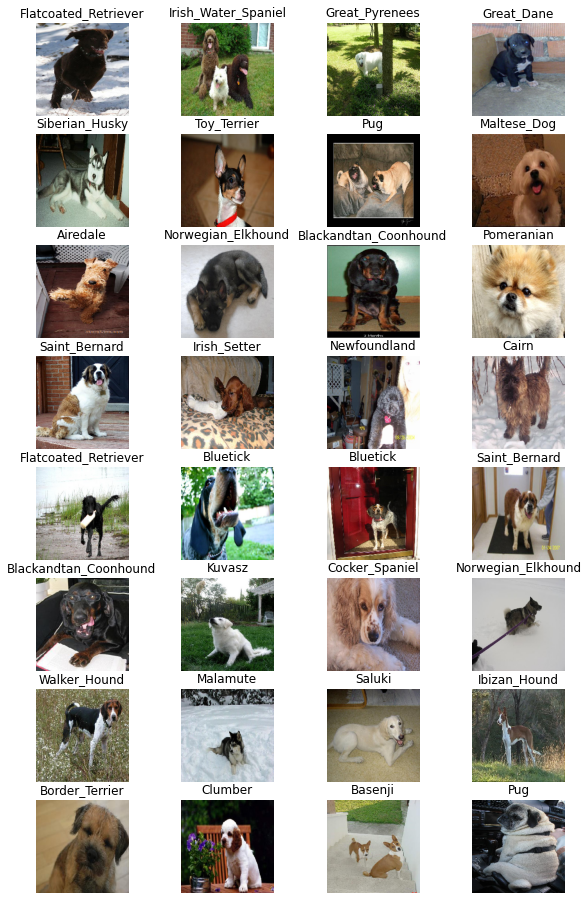

In [30]:
def show_batch(image_batch, label_batch):
  fig = plt.figure(figsize=(10,16))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(8,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(unique_breeds[label_batch[n]==1][0].title(), fontsize=12)
      plt.axis('off')
    
image_batch, label_batch = next(train_data)
show_batch(image_batch, label_batch)

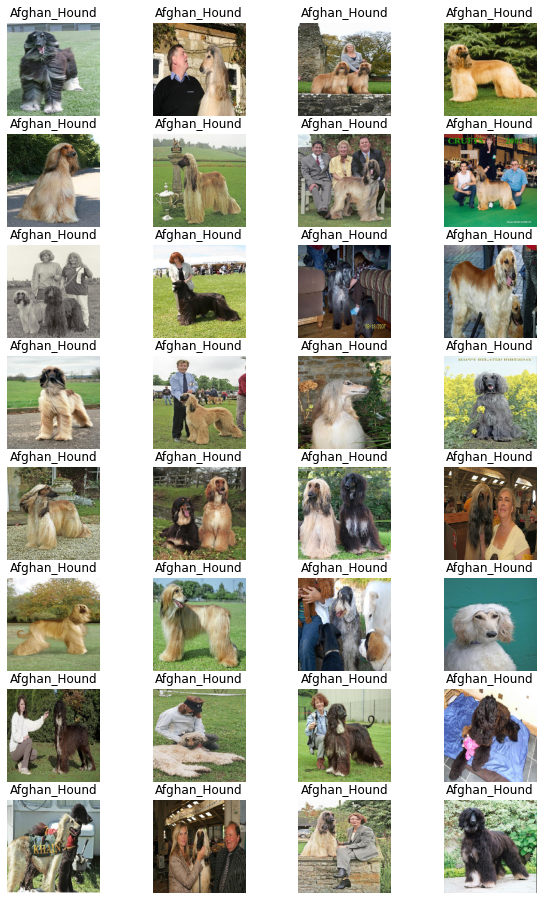

In [32]:
valid_image, valid_label = next(valid_data)
show_batch(valid_image, valid_label)

# Building a Model !

Before we build a model, there are a few things we need to define:
* The input shape (image shape in the form of Tensors)
* The output shape (image labels in the form of Tensors)
* URL of model we want to use Transfer Learning with from TensorFlow Hub
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

^^ MobileNet Image Classification (Size = 224x224, Depth Multiplier = 1.3)

In [31]:
#setup input shape into the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channel

#setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

#setup model URL from Tensorflow HUB
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our Inputs, Outputs, and Model ready...
Lets put them together into a Keras Deep Learning Model!

Knowing this, let's create a function that:
* takes input shape, output shape, and model as parameters
* Defines the layers of KEras Model in a sequential fashion
* Compiles the model (Says it should be evaluated and improved)
* Builds model (Tell model the input shape it'll be getting)
* Return the model

All the steps can be found in https://www.tensorflow.org/guide/keras/overview

In [ ]:
# Create a Function which builds a Keras Model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print(f"Building model with {MODEL_URL}")

  # Setup Model Layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (Input Layer)
    tf.keras.layers.Dense(units=output_shape, 
                          activation="softmax") # Layer 2 (Output Layer)       
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics =["accuracy"]
  )

  # Build Model
  model.build(input_shape)

  return model

In [ ]:
model = create_model()
model.summary()

## Creating Callbacks

Callbacks are helper functions a model can use during training to:
* Save its progress
* Check its progress
* Stop Training early if it stops improving

We'll create 2 callbacks,
- One is for TensorBoard, helps track our model progress
- Second is for early stopping, prevents model from training too long (becoming overfitted)


### TensorBoard Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

To setup the Tensorboard Callback, we need to:
1. Load a TensorBoard notebook Extension
2. Create a Tensorboard Callback which save logs to a directory and pass it to the model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training)

In [ ]:
# Load TensorBoard Notebook Extension
%load_ext tensorboard

import datetime

# Create TensorBoard Callback Function
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("Logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # Tracks time everytime we run experiment
                        )
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Helps model from overfitting by stopping training if a certain evaluation metric stops improving

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=10)

### Model Checkpoint Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

Callback to save the Keras model or model weights at some frequency.

In [ ]:
def create_model_checkpoint(suffix=None):
    modeldir = os.path.join("Models",
                          datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%s"))
    
    model_path = modeldir + "-" + suffix
    return tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss',save_best_only=True)

Let's create a function which trains a model.

* Create a model using `create_model`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, num of epochs to train for (`NUM_EPOCHS`), and callbacks
* Return Model

In [ ]:
NUM_EPOCHS = 100

def train_model(train_data, valid=False, val_data=None):
    """
    Trains a given model and returns the trained version.
    """

    # Create model
    model = create_model()

    # Create new TensorBoard session everytime we train the model
    tensorboard = create_tensorboard_callback()
    checkpoint = create_model_checkpoint("trained_1000")
    # Fit the model
    if valid:
        # Create early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=10)
        model.fit(x=train_data,
                epochs=NUM_EPOCHS,
                validation_data=val_data,
                validation_freq=1,
                callbacks=[tensorboard, early_stopping, checkpoint]
                )
    else:
        # Create early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                  patience=10)
        model.fit(x=train_data,
                epochs=NUM_EPOCHS,
                callbacks=[tensorboard, early_stopping]
                )
  
    # Return the fitted model
    return model

# With all prepared, it is time to train the model with the 
## To start off, lets try training 1000 data first

In [ ]:
from sklearn.model_selection import train_test_split

# Fit the model to data
model = train_model(train_data, valid=True, val_data=valid_data)

### Checking the TensorBoard Logs

the Tensor board function `%tensorboard` will access the logs we created and visualize its content

In [ ]:
%tensorboard --logdir Logs

## Make a prediction using the trained model and evaluate VISUALLY

In [ ]:
# Make Predictions on validation data (not trained on)

preds = model.predict(valid_data, verbose=1)
preds

In [ ]:
train_data[0][1][1]

In [ ]:
# Lets make a function that convert the array of numbers into a label prediction...
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# get_pred_label(pred[0])

In [ ]:
# Function to unbatch datasets
def unbatchify(data):
  """
  Takes batched dataset of (image, labels) Tensors and 
  returns separate arrays of images and labels.
  """

  images_ = []
  labels_ = []
  # Loop through unbatched data and unbatch em
  for image, label in data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(get_pred_label(label))

  return images_, labels_

# unbatched_image, unbatched_label = unbatchify()
# unbatched_image[0], unbatched_label[0]

In [ ]:
# Personal function to check accuracy of prediction
def preds_check(index=0,preds=preds, verbose=False):
  if verbose:
    print(preds[index])
  print(f"Max value (probability of prediction) : {np.max(preds[index])}")
  print(f"Sum : {np.sum(preds[index])}")
  print(f"Max Index: {np.argmax(preds[index])}")
  print(f"Predicted label: {get_pred_label(preds[index])}")
  print(f"Actual label: {unbatched_label[index]}")

In [ ]:
preds_check(0)

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change color if right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  # Change plot title to predicted, prob predicted, truth label
  plt.title("{} / {:2.2f}% / {}".format(pred_label, 
                                        np.max(pred_prob)*100,
                                        true_label),
            color=color)

    
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], get_pred_label(labels[n])

  # Get predicted label
  pred_label = get_pred_label(pred_prob)

  # Find top 10 prediction confidence indexes
  top_10_pred_index = pred_prob.argsort()[-10:][::-1]
  # Find top 10 prediction confidence values
  top_10_pred_value = pred_prob[top_10_pred_index]
  # Find top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_index]

  # Plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_value,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color
  if np.isin(true_label, top_10_pred_labels).any():
    print("Truth Label = ", true_label)
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")

In [ ]:
plot_pred(preds,unbatched_label,unbatched_image, 4)

In [ ]:
plot_pred_conf(preds, unbatched_label, 4)

## Saving and reloading a trained model

In [ ]:
# Create a function to save model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix(string)
  """

  # Create model directory pathname. with current time
  modeldir = os.path.join("Models",
                          datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%s"))
  model_path = modeldir + "-" + suffix + ".h5"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

# Create a function to load model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer" : hub.KerasLayer})
  return model


In [ ]:
# Save a model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

In [ ]:
# Load a model trained on 1000 images
loaded_1000_image_model = load_model("Models/2022:06:25-08:071656144422-1000-images-mobilenetv2-Adam.h5")

In [ ]:
loaded_1000_image_model.evaluate(val_batch)

## NOW, lets train the mode with the full data

In [ ]:
from sklearn.model_selection import train_test_split

#Split to train and validation
x_train, x_val, y_train, y_val = train_test_split(x, 
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)
print(len(x_train), len(y_train), len(x_val), len(y_val))

train_batch = create_data_batches(x_train, y_train)
val_batch = create_data_batches(x_val, y_val, valid_data=True)
train_batch, val_batch

In [ ]:
# Create full model
full_model = create_model()
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3) # Stops when accuracy does not improve for 3 epochs

In [ ]:
# Fit the model to full data
full_model.fit(x=train_batch,
                epochs=100,
                validation_data=val_batch,
                validation_freq=1,
                callbacks=[full_model_tensorboard, full_model_early_stopping]
                )

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

## Testing the loaded full model on some custom images

In [ ]:
loaded_full_model = load_model("Models/2022:06:29-07:471656488859-full-image-set-mobilenetv2-Adam.h5")

In [ ]:
custom_images = [ "Images/custom-images/" + fname for fname in os.listdir("Images/custom-images")]
custom_images

In [ ]:
custom_batch = create_data_batches(custom_images, test_data=True)
custom_batch

In [ ]:
custom_predictions = loaded_full_model.predict(custom_batch)
custom_predictions

## Let's make a function to do 

In [ ]:
# COMPLETE DOG BREED PREDICTION FUNCTION
def dog_breed_predict(filename_list: list, model):
  # Turn images into batch datasets
  file_batch = create_data_batches(filename_list, test_data=True)
  # Make predictions on the data
  prediction = model.predict(file_batch)
  # Get custom image prediction labels
  custom_pred_labels = [get_pred_label(i) for i in prediction]
  # Unbatch batched datasets
  custom_images = []
  for image in file_batch.unbatch().as_numpy_iterator():
    custom_images.append(image)
  # Plot results
  no_rows = len(filename_list)//3 + (0 if (len(filename_list)%3 == 0) else 1)
  no_cols = 3
  if len(filename_list) < 3:
    no_cols = len(filename_list) * 3

  plt.figure(figsize=(3*no_cols,3*no_rows))
  for i, image in enumerate(custom_images):
    # Confidence percentage
    confidence_perc = np.max(prediction[i])*100

    # Coloring based on confidence
    if confidence_perc >= 85:
        color = "green"
    elif confidence_perc >= 70:
        color = "blue"
    elif confidence_perc >= 50:
        color = "orange"
    else:
        color = "red"
       
    plt.subplot(no_rows,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title("{} / {:2.2f}%".format(custom_pred_labels[i], confidence_perc), color=color)
    plt.imshow(image)

In [ ]:
dog_breed_predict(custom_images, loaded_full_model)

In [ ]:
idx = custom_predictions[1].argsort()[-10:][::-1]
for i in idx:
  print((unique_breeds[i] , f"{custom_predictions[1][i]*100} %"))

# Data Augmentation for further improvement on model (Enrichment of training data)

In [ ]:
def augment_image(image, seed):
  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical",seed=seed),
    tf.keras.layers.RandomRotation(0.2,seed=seed),
    tf.keras.layers.RandomZoom(0.2,seed=seed),
    tf.keras.layers.RandomCrop(height=IMG_SIZE, width=IMG_SIZE,seed=seed),
    tf.keras.layers.RandomContrast(0.25,seed=seed)
  ])
  return data_augmentation(image)
  
# Show example of augmentations
image = process_image(custom_images[1])
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

plt.figure(figsize=(10, 8))
for i in range(9):
  augmented_image = augment_image(image, i)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
# Lets create a function that augments the data when creating a tuple (image, label)
def get_augmented_image_tuple(filename, label, seed=0):
  """
  Takes an image file path and label
  then processes & augments and return a tuple (image, label)
  """
  image = process_image(filename)
  return augment_image(image, seed), label

In [ ]:
# Lets update the batching function
BATCH_SIZE = 32

#function to turn data to batches
def create_data_batches(x, y=None, batch_size=32, valid_data=False, test_data=False, augment=False, seed=0):
  """
  Create batches of data out of (image x) and (label y) pairs.
  Shuffles the data if its training data, but not when validation data.
  Also accepts test data as input (no labels).
  """
  #If test dataset, we probably don't have labels
  if test_data:
    print(f"Creating test data batches... BATCH SIZE={batch_size}")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data_batch = data.map(process_image).batch(batch_size)

  #If validation dataset, we don't need to shuffle
  elif valid_data:
    print(f"Creating validation data batches... BATCH SIZE={batch_size}")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), #filepath
                                              tf.constant(y))) # labels
    if augment:
      print(f"Augmenting seed = {seed}")
      data = data.map(lambda data, seed : get_augmented_image_tuple(data, seed))
    else:
      data = data.map(get_image_tuple)
    data_batch = data.batch(batch_size)
  
  else:
    print(f"Creating training data batches... BATCH SIZE={batch_size}")
    #turn filepath and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), #filepath
                                              tf.constant(y))) # labels
    #shuffle
    data = data.shuffle(buffer_size=len(x))

    #process into (image,label) tuple and make batch
    if augment:
      print(f"Augmenting seed = {seed}")
      data = data.map(lambda data, seed : get_augmented_image_tuple(data, seed))
    else:
      data = data.map(get_image_tuple)
    data_batch = data.batch(batch_size)
  return data_batch

In [ ]:
#Create function for viewing images in data batches

def show_32_images(images, labels):
  """
  Display a plot of 25 images and their labels from data batch
  """
  plt.figure(figsize=(10,16))
  for i in range(32):
    #create subplots 4x8
    ax = plt.subplot(8,4, i+1)
    #Display Image
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    #remove axis
    plt.axis("off")

## First Iteration of Data Augmentation Training
Augment seed #0

In [ ]:
train_augment_batch = create_data_batches(x_train, y_train, augment=True, seed=0)
val_augment_batch = create_data_batches(x_val, y_val, valid_data=True, augment=True, seed=0)
train_augment_batch, val_augment_batch

In [ ]:
train_images, train_labels = next(train_augment_batch.as_numpy_iterator()) #This function unbatches it into a numpy array
len(train_images), len(train_labels) #shows shape 32,32 since its batch size is 32...

In [ ]:
show_32_images(train_images, train_labels)

### Now that we've augmented the dataset batches, let us incremently fit it into the previously trained model

In [ ]:
# Create full model callbacks
full_augment_model_tensorboard = create_tensorboard_callback()
full_augment_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3) # Stops when accuracy does not improve for 3 epochs

In [ ]:
# Fit the model to full data
loaded_full_model.fit(x=train_augment_batch,
                epochs=100,
                validation_data=val_augment_batch,
                validation_freq=1,
                callbacks=[full_augment_model_tensorboard, full_augment_model_early_stopping]
                )

In [ ]:
save_model(loaded_full_model, suffix="full-augment0-image-set-mobilenetv2-Adam")

In [ ]:
load_augment_model = load_model("Models/2022:06:29-08:541656492878-full-augment0-image-set-mobilenetv2-Adam.h5")

In [ ]:
dog_breed_predict(custom_images, load_augment_model)

In [ ]:
load_augment_model.evaluate(val_batch)

In [ ]:
load_augment_model.evaluate(val_augment_batch)

In [ ]:
loaded_full_model.evaluate(val_batch)

In [ ]:
loaded_full_model.evaluate(val_augment_batch)

### Evaluation after 1st iteration of augmented data fitting
As seen above, the accuracy of the `load_augment_model` has a slightly worse accuracy than the `loaded_full_model` when evaluating the normal validation data batches. BUT it performs **WAY BETTER** than the latter when evaluating the augmented validation data batches.

> This shows improvement in terms of the `model's overall scope` because it is generally performing better for all types of images (both normal and augmented)

**Note:**
 Realistically, people do not always has perfect images of dogs, so our model needs to be able to predict images that may be slightly augmented (translated, rotated, brightness, contrast, cropped, etc)

## Second Iteration of Data Augmentation Training
Augment seed #1

In [ ]:
# THEN WE AUGMENT IT AGAIN...
train_augment1_batch = create_data_batches(x_train, y_train, augment=True, seed=1)
val_augment1_batch = create_data_batches(x_val, y_val, valid_data=True, augment=True, seed=1)
train_augment1_batch, val_augment1_batch

In [ ]:
train_images, train_labels = next(train_augment1_batch.as_numpy_iterator()) #This function unbatches it into a numpy array
show_32_images(train_images, train_labels)

### Now that we've got our 2nd augmented data, lets fit it again

In [ ]:
load_augment_model = load_model("Models/2022_06_29-08_541656492878-full-augment0-image-set-mobilenetv2-Adam.h5")

In [ ]:
# Create full model callbacks
full_augment1_model_tensorboard = create_tensorboard_callback()
full_augment1_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3) # Stops when accuracy does not improve for 3 epochs

In [ ]:
# Fit the model to full data
load_augment_model.fit(x=train_augment1_batch,
                epochs=100,
                validation_data=val_augment1_batch,
                validation_freq=1,
                callbacks=[full_augment1_model_tensorboard, full_augment1_model_early_stopping]
                )

In [ ]:
saved_path = save_model(load_augment_model, suffix="full-augment1-image-set-mobilenetv2-Adam")

In [ ]:
from google.colab import files
files.download(saved_path)

In [ ]:
augment1_model = load_model("Models/2022:06:30-05:151656566150-full-augment1-image-set-mobilenetv2-Adam.h5")

In [ ]:
dog_breed_predict(custom_images, augment1_model)

In [ ]:
def evaluate_model(model_before, model_after, normal_batch, augment_batch):
  """
  Evaluates model and compare it with the previous model
  """
  print("NORMAL BATCH EVALUATION")
  print("Previous Model:")
  model_before.evaluate(normal_batch)
  print("New Model:")
  model_after.evaluate(normal_batch)
  print("\nAUGMENTED BATCH EVALUATION")
  print("Previous Model:")
  model_before.evaluate(augment_batch)
  print("New Model:")
  model_after.evaluate(augment_batch)

In [ ]:
evaluate_model(load_augment_model, augment1_model, val_batch, val_augment1_batch)

### Evaluation after 2nd iteration of augmented data fitting
As seen above, the model's accuracy on normal batch is yet again decreasing, but this time it shows worse accuracy on the augmented batch.
For the reason stated, we will be continuing with the previous model

## Third Iteration of Data Augmentation Training
Augment seed #2

In [ ]:
train_augment2_batch = create_data_batches(x_train, y_train, augment=True, seed=2)
val_augment2_batch = create_data_batches(x_val, y_val, valid_data=True, augment=True, seed=2)
train_augment2_batch, val_augment_batch

In [ ]:
train_images, train_labels = next(train_augment2_batch.as_numpy_iterator()) #This function unbatches it into a numpy array
len(train_images), len(train_labels) #shows shape 32,32 since its batch size is 32...

In [ ]:
show_32_images(train_images, train_labels)

### Augmented Data Fitting

In [ ]:
loaded_model = load_model("Models/2022_06_29-08_541656492878-full-augment0-image-set-mobilenetv2-Adam.h5")

In [ ]:
# Create full model callbacks
full_augment2_model_tensorboard = create_tensorboard_callback()
full_augment2_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3) # Stops when accuracy does not improve for 3 epochs

In [ ]:
# Fit the model to full data
loaded_model.fit(x=train_augment2_batch,
                epochs=100,
                validation_data=val_augment2_batch,
                validation_freq=1,
                callbacks=[full_augment2_model_tensorboard, full_augment2_model_early_stopping]
                )

In [ ]:
saved_path = save_model(loaded_model, suffix="full-augment2-image-set-mobilenetv2-Adam")

In [ ]:
loaded_augment2 = load_model(saved_path)

In [ ]:
dog_breed_predict(custom_images, loaded_augment2)

In [ ]:
prev_model = load_model("/content/Models/2022_06_29-08_541656492878-full-augment0-image-set-mobilenetv2-Adam.h5")

In [ ]:
evaluate_model(prev_model, loaded_augment2, val_batch, val_augment2_batch)

### Evaluation after 3rd iteration of augmented data fitting
As seen above, the model's accuracy on normal batch is yet again decreasing, but this time it shows worse accuracy on the augmented batch.
For the reason stated, we will be continuing with the previous model

## 3rd Iteration of Augmented Data Training
Augment seed #3

In [ ]:
def augment_training(prev_model_path, seed, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, custom_images=custom_images, val_batch=val_batch):
  """
  Function for the entire Iteration of Augmented data training
  """
  # Augmentation
  train_augment_batch = create_data_batches(x_train, y_train, augment=True, seed=seed)
  val_augment_batch = create_data_batches(x_val, y_val, valid_data=True, augment=True, seed=seed)

  # Training prep
  model = load_model(prev_model_path)
  full_augment_model_tensorboard = create_tensorboard_callback()
  full_augment_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3) # Stops when accuracy does not improve for 3 epochs
  
  # Fit the model to full data
  loaded_model.fit(x=train_augment_batch,
                epochs=100,
                validation_data=val_augment_batch,
                validation_freq=1,
                callbacks=[full_augment_model_tensorboard, full_augment_model_early_stopping]
                )
  saved_path = save_model(loaded_model, suffix=f"full-augment{seed}-image-set-mobilenetv2-Adam")
  
  # Evaluation
  prev_model = load_model(prev_model_path)
  dog_breed_predict(custom_images, loaded_model)
  evaluate_model(prev_model, loaded_model, val_batch, val_augment_batch)

In [ ]:
augment_training("Models/2022_06_29-08_541656492878-full-augment0-image-set-mobilenetv2-Adam.h5", 3)

In [ ]:
augment_training("Models/2022:06:30-07:121656573132-full-augment3-image-set-mobilenetv2-Adam.h5", 4)

In [ ]:
!zip -r Logs.zip Logs

In [ ]:
augment_training("/content/Models/2022:06:30-07:451656575156-full-augment4-image-set-mobilenetv2-Adam.h5", 5)

In [ ]:
augment_training("/content/Models/2022:06:30-08:221656577369-full-augment5-image-set-mobilenetv2-Adam.h5", 6)

In [ ]:
augment_training("/content/Models/2022_06_30-08_48_1656578928-full-augment6-image-set-mobilenetv2-Adam.h5", 7)

In [ ]:
augment_training("Models/2022_06_30-09_27_1656581275-full-augment7-image-set-mobilenetv2-Adam.h5", 8)

In [ ]:
!zip -r Models.zip Models

In [ ]:
!zip -r Logs.zip Logs

In [ ]:
augment_training("Models/2022_06_30-09_54_1656582840-full-augment8-image-set-mobilenetv2-Adam.h5", 9)